# Example of predicting sand thickness 
This example demonstrates how GeoST can be used to prepare data for predicting the
total thickness of sand within the first 4 meters below the surface based on boreholes
in the GDN database. The predictor will be trained on location (x/y coordinates), AHN 
elevation, geological map units and  geomorphological map units. For the prediction a 
gradient boost regressor algorithm will be employed, which is provided by the 
scikit-learn package.

Let's first import geost and other required packages:

In [3]:
from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    BaggingRegressor,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To check model performance
from sklearn.metrics import r2_score, mean_absolute_error

# To be used for creating pipelines and personalizing them

import matplotlib.pyplot as plt
import xarray as xr

import geost
from geost.spatial import find_area_labels, get_raster_values
from geost.utils import dataframe_to_geodataframe
import seaborn as sns

import shap

Let's check the version of GeoST we're on:

In [4]:
print(geost.__version__)

0.2.4


These are the paths to the different data that we will use in this example:

In [5]:
resource_folder = Path.cwd() / 'resources'

study_area = resource_folder / 'study_area.shp'
gdn_data_file = resource_folder / 'GDN_borehole_data.parquet'
geological_map_file = resource_folder / 'BRO_geological_map.geoparquet'
geomorphological_map_file = resource_folder / 'BRO_geomorphological_map.geoparquet'
ahn_file = resource_folder / 'ahn.tif'


# Data preparation with GeoST
We will prepare the data first to make the appropriate selections, to add geological
and geommorphological map information to the boreholes and of course to get our training
target: the cumulative thickness of sand layers in the first 4 m.

In [6]:
gdn_data = geost.read_borehole_table(gdn_data_file)
print(gdn_data.n_points)

28628


gdn_data is a `BoreholeCollection` containing 28628 boreholes. We will first select 
boreholes within the study area using the method `select_within_polygons`. Our study
area shapefile contains one simple polygon, but more complex shapes and multiple
polygons are also supported.

In [7]:
gdn_data_selection = gdn_data.select_within_polygons(study_area)

print(gdn_data_selection.n_points)

20545


We now have 20545 boreholes left. Since we want to get the total thickness of sand 
within the first 4 m to train the model, we also need to select boreholes that are at 
least 4 m in length, because otherwise we will get an unwanted bias in our target data.
In addition we will cut off boreholes at 4 m, so all boreholes in the collection will be
exactly 4 m in length.

In [8]:
gdn_data_selection = gdn_data_selection.select_by_length(min_length=4)
gdn_data_selection = gdn_data_selection.slice_depth_interval(0, 4)

print(gdn_data_selection.n_points)

17574


This is our final filter, so we will be working with these 17574 boreholes. Next, we 
calculate the total thickness of sand within each borehole using the `get_cumulative_layer_thickness` method. 
These will be our target values to predict in the machine learning model!

In [9]:
# In the data column 'lith', calculate cumulative thickness of layers labelled 'Z' (sand)
# and include the results in the header table.
gdn_data_selection.get_cumulative_layer_thickness("lith", "Z", include_in_header=True)

The header table should now include a column called 'Z_thickness', let's check that:

In [10]:
gdn_data_selection.header[["nr", "Z_thickness"]]

,nr,Z_thickness
0,B38A0048,0.00
1,B38A0050,0.00
2,B38A0239,0.00
3,B38A0241,0.00
4,B38A0254,0.00
...,...,...
17569,B45A2789,1.42
17570,B45A2790,1.80
17571,B45A2792,0.30
17572,B45A2794,0.90


As we will use features from the geological and geomorphological map, we will now add
the geological and geomorphological areas in which our data points are located to the 
header dataframe using the built-in `get_area_labels` method:

In [11]:
# Read it like: from the geological map, get the value in the field "CODE" and add
# it to the header.
gdn_data_selection.get_area_labels(geological_map_file, "CODE", include_in_header=True)
gdn_data_selection.get_area_labels(
    geomorphological_map_file, "landformsubgroup_code", include_in_header=True
)

You can check that the columns "CODE" (geological map unit codes) and "landformsubgroup_code"
(geomorphological map unit codes) were added to each borehole in the header table:

In [12]:
gdn_data_selection.header[["nr", "CODE", "landformsubgroup_code"]]

,nr,CODE,landformsubgroup_code
0,B38A0048,kvo*,M81
1,B38A0050,kvo*,M81
2,B38A0239,kvo*,M81
3,B38A0241,kvo*,M81
4,B38A0254,kvo*,M81
...,...,...,...
17569,B45A2789,k,H43
17570,B45A2790,b,L42
17571,B45A2792,k,NaN
17572,B45A2794,k,NaN


## EDA analysis

The Exaploratory Data Analysis (EDA) provides a sense of the data you are working with. This includes understanding the distribution of variables, identifying patterns, and recognizing anomalies. This foundational understanding is critical for making informed decisions throughout the machine learning process. Thus, we explore the characteristics and correlations of the difference features of the dataset. 

<Axes: xlabel='x', ylabel='y'>

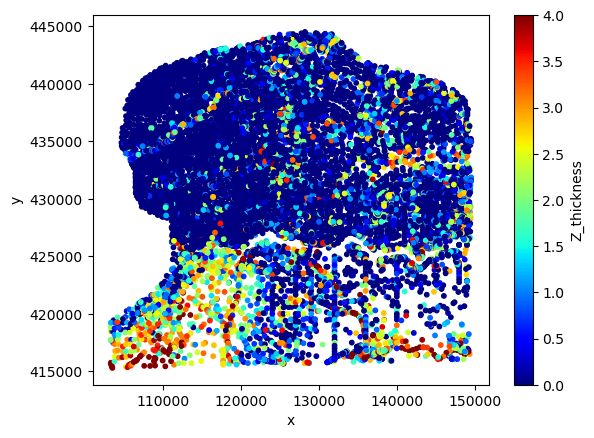

In [13]:
# create dataframe to perform EDA and feature engineering
df = gdn_data_selection.header.gdf
df.plot.scatter(x="x", y="y", c="Z_thickness", cmap="jet", s=10)

In [14]:
# List of all important categorical variables
cat_col = ["CODE", "landformsubgroup_code"]

# Printing the number of occurrences of each unique value in each categorical column
for column in cat_col:
    print(df[column].value_counts(1)*100)
    print("-" * 50)

CODE
kvo*    42.096279
k       35.438716
b        9.047456
kb       7.004666
kg*      5.035848
g        0.637305
BX3      0.381245
ov       0.358484
Name: proportion, dtype: float64
--------------------------------------------------
landformsubgroup_code
M81    31.808531
M46    18.439169
B44    16.586245
H43     6.556006
M48     5.352892
M72     5.211349
L74     2.579940
L42     1.840057
N94     1.556971
B71     1.254584
B72     1.190246
M93     1.087306
R71     1.010101
G41     0.952197
M79     0.887859
R43     0.636943
B45     0.617641
B47     0.521135
B57     0.476099
L43     0.392460
M47     0.257351
L91     0.225182
F91     0.199447
R44     0.102940
M45     0.083639
B91     0.083639
M78     0.057904
M84     0.019301
N41     0.006434
H44     0.006434
Name: proportion, dtype: float64
--------------------------------------------------


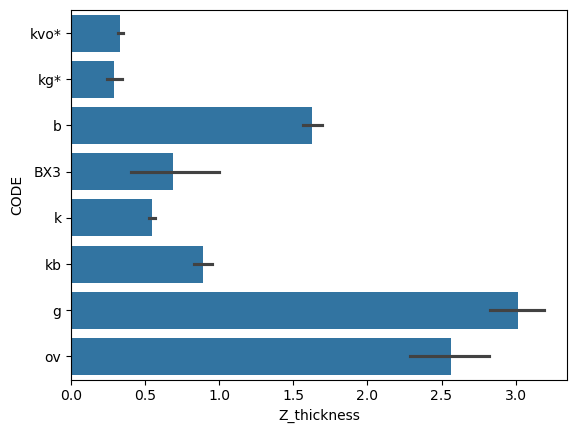

In [15]:
sns.barplot(y = 'CODE', x = 'Z_thickness', data = df)
plt.show()

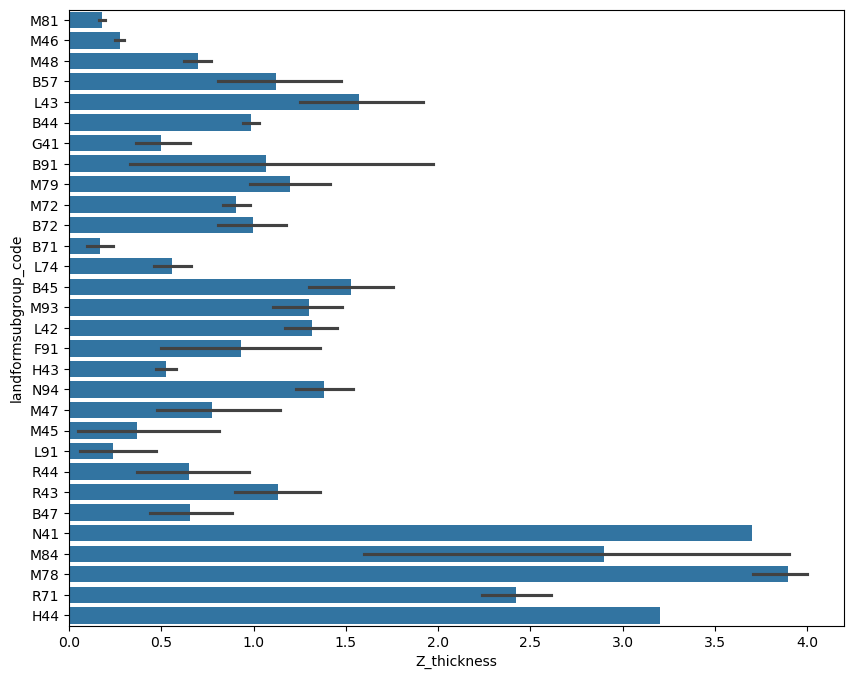

In [16]:
plt.figure(figsize = (10,8))
sns.barplot(y = "landformsubgroup_code", x = 'Z_thickness', data = df)
plt.show()

<Axes: >

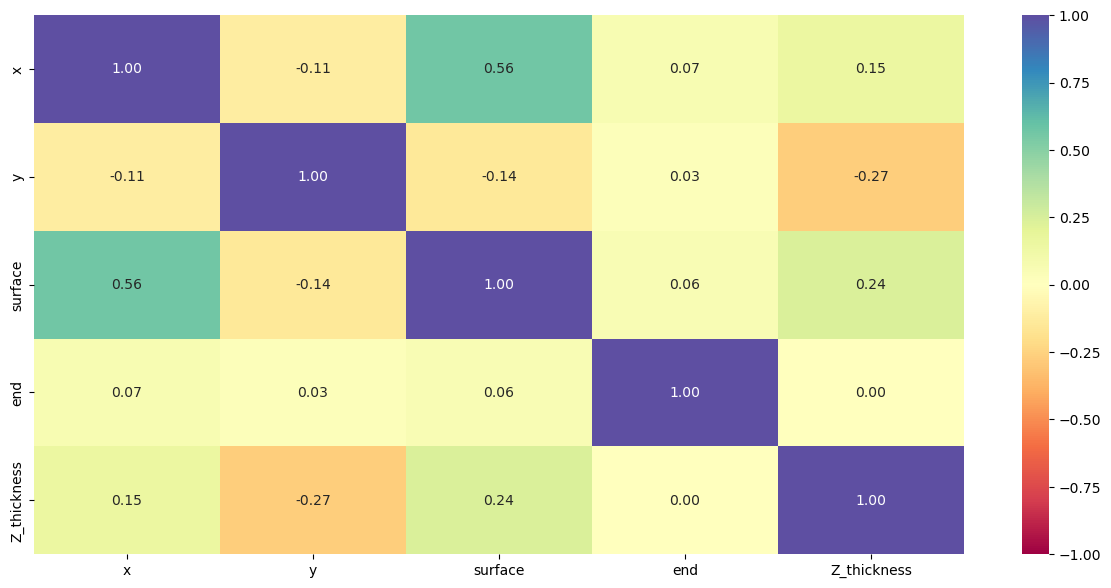

In [17]:
# Finding the correlation between various columns of the dataset
plt.figure(figsize = (15,7))
sns.heatmap(df.corr(numeric_only=True), annot = True, vmin = -1, vmax = 1, fmt = ".2f", cmap = "Spectral")

### Observations:

- The geological unit codes show that the thickness can be splitted in two main groups: (1): CODES: k, kv, BX3, kg*, kvo*, which are less or equal than 1 m. (2) CODES: g, ov, b, which are more than 1.0 m thickness. 
- Something similar occurs with the geomorpholical unit map codes, where most of the codes correspond to thicknesses less than 2.0 m, and CODES: N41, M84, M78, R71, and H44 are thicker that 2.0 m.
- The correlation matrix shows that the highest correlation (0.56) occurs between x-coordiante and surface. The thickness seems to correlation more or less well (0.27) with surface and x coordinates.


## Data preparation for model building

In [18]:
# Apply one-hot encoding
data_encoded_geology = pd.get_dummies(df["CODE"])
data_encoded_morphology = pd.get_dummies(df["landformsubgroup_code"]
)

# Extract features from the borehole header and join with one-hot encoded geological
# and geomorphological feature columns
features = df[
    [
        "x",
        "y",
        "surface",
    ]
]
features = features.join(data_encoded_geology).join(data_encoded_morphology)

# Get target values from the borehole header (the Z_thickness column)
targets = df["Z_thickness"]

In [19]:
# Split the features and targets into training and testing sets (80/20)
features_train, features_test, targets_train, targets_test = train_test_split(
    features,
    targets,
    test_size=0.2,
)

## Model building

We will be using different metrics functions defined in sklearn like RMSE, MAE, 𝑅2, and Adjusted 𝑅2. We will define a function to calculate these metrics.

In [20]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    pred = model.predict(predictors)                  # Predict using the independent variables
    r2 = r2_score(target, pred)                       # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)    # To compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # To compute RMSE
    mae = mean_absolute_error(target, pred)           # To compute MAE

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
        },
        index=[0],
    )

    return df_perf

## Random Forrest regressor

In Random Forest Regression, each individual decision tree within the forest provides a prediction for a given input, and the final prediction is the average of these individual predictions. You can interpret the distribution of the predictions from the individual trees to gain insight into the uncertainty of the prediction. This is somewhat analogous to calculating probabilities.

In [21]:
# Create the scikit-learn gradient boosting regressor with given hyperparameters
rf_model = RandomForestRegressor(random_state=1)

# Fit the model using test features and targets (80% of the dataset)
rf_model.fit(features_train, targets_train)

# Model Performance on the test data
rf_regressor_perf_test = model_performance_regression(rf_model, features_test, targets_test)

rf_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared
0,0.762649,0.473882,0.446284,0.439747


## Bagging Regressor

Bagging (short for Bootstrap Aggregating) is an ensemble learning technique that involves training multiple models on different subsets of the training data and then combining their predictions. The idea is to reduce variance and overfitting by averaging the predictions of many models.

A Bagging Regressor is a type of Bagging algorithm used for regression tasks. It involves training multiple regression models (e.g., Decision Trees) on different subsets of the training data and then combining their predictions by taking the average.

In [22]:
# Bagging Regressor
bg_estimator = BaggingRegressor(random_state = 1)

# Fitting the model
bg_estimator.fit(features_train, targets_train)

# Model Performance on the test data
bagging_estimator_perf_test = model_performance_regression(bg_estimator, features_test, targets_test)

bagging_estimator_perf_test

,RMSE,MAE,R-squared,Adj. R-squared
0,0.794455,0.483551,0.399136,0.392042


## Gradient Boosting Regressor

Gradient Boosting is another boosting algorithm that combines multiple weak learners to create a strong learner. The difference between Adaboost and Gradient Boosting is that the former assigns different weights to different data points, while the latter fits the model to the residual errors of the previous model.

In [23]:
# Gradient Boosting Regressor
grad_regressor = GradientBoostingRegressor(random_state=1)

# Fitting the model
grad_regressor.fit(features_train, targets_train)

# Model Performance on the test data
grad_regressor_perf_test = model_performance_regression(grad_regressor, features_test, targets_test)

grad_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared
0,0.819018,0.564395,0.361406,0.353867


## XGBoost Regressor

XGBoost (short for Extreme Gradient Boosting) is a highly optimized implementation of the Gradient Boosting algorithm. 

In [24]:
# XGBoost Regressor
xgb = XGBRegressor(random_state = 1)

# Fitting the model
xgb.fit(features_train, targets_train)

# Model Performance on the test data
xgb_perf_test = model_performance_regression(xgb, features_test, targets_test)

xgb_perf_test

,RMSE,MAE,R-squared,Adj. R-squared
0,0.763111,0.494106,0.445613,0.439068


## Models performance

Comparing different machine learning models is an important step in the modeling process, as it allows us to understand the strengths and weaknesses of each model, and to choose the best one for a particular task.

In the context of regression, we can compare models based on various performance metrics, such as **Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), R-squared, Adjusted R-squared and others**.

In [25]:
models_test_comp_df = pd.concat(
    [
        bagging_estimator_perf_test.T,
        rf_regressor_perf_test.T,
        grad_regressor_perf_test.T,
        xgb_perf_test.T
    ],
    axis = 1,
)

models_test_comp_df.columns = [
    "Bagging Regressor",
    "Random Forest regressor",
    "Gradient Boosting Regressor",
    "XG Boost Regressor"]



In [26]:
# Highlighting the minimum value in each column
print("Minimum values for each column:")
models_test_comp_df.T.style.highlight_min(color = "green", axis = 0)

Minimum values for each column:


,RMSE,MAE,R-squared,Adj. R-squared
Bagging Regressor,0.794455,0.483551,0.399136,0.392042
Random Forest regressor,0.762649,0.473882,0.446284,0.439747
Gradient Boosting Regressor,0.819018,0.564395,0.361406,0.353867
XG Boost Regressor,0.763111,0.494106,0.445613,0.439068


In [27]:
# Highlighting the maximum value in each column
print("Maximum values for each column:")
models_test_comp_df.T.style.highlight_max(color = "red", axis = 0)

Maximum values for each column:


,RMSE,MAE,R-squared,Adj. R-squared
Bagging Regressor,0.794455,0.483551,0.399136,0.392042
Random Forest regressor,0.762649,0.473882,0.446284,0.439747
Gradient Boosting Regressor,0.819018,0.564395,0.361406,0.353867
XG Boost Regressor,0.763111,0.494106,0.445613,0.439068


### Observations:

The **Random Forest** has the **lowest RMSE and MAE**, indicating that the average difference between predicted and actual values is the smallest. It also has a **higher R-squared and Adjusted R-squared**, indicating that the model explains a significant proportion of the variance in the target variable. 

## Tuning Model

In [28]:
rf_tuned = RandomForestRegressor(random_state = 1)

# Grid of parameters to choose from
rf_parameters = {"n_estimators": [100, 200, 300],
              
    "max_depth": [5, 10, None],
              
    "max_features": [0.8, 1]
             }

# Run the grid search
rf_grid_obj = GridSearchCV(rf_tuned, rf_parameters, scoring = 'neg_mean_squared_error', cv = 5)

rf_grid_obj = rf_grid_obj.fit(features_train, targets_train)

# Set the rf_tuned_regressor to the best combination of parameters
rf_tuned_regressor = rf_grid_obj.best_estimator_

rf_tuned_regressor.fit(features_train, targets_train)

# Model Performance on the test data
rf_tuned_regressor_perf_test = model_performance_regression(rf_tuned_regressor, features_test, targets_test)

rf_tuned_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared
0,0.752803,0.471873,0.460489,0.45412


## Choosing the final model

In [29]:
models_test_comp_df = pd.concat(
    [
        bagging_estimator_perf_test.T,
        rf_regressor_perf_test.T,
        grad_regressor_perf_test.T,
        xgb_perf_test.T,
        rf_tuned_regressor_perf_test.T,
    ],
    axis = 1,
)

models_test_comp_df.columns = [
    "Bagging Regressor",
    "Random Forest regressor",
    "Gradient Boosting Regressor",
    "XG Boost Regressor",
    "Random Forest Tuned Regressor"]

print("Test performance comparison:")

models_test_comp_df.T

Test performance comparison:


,RMSE,MAE,R-squared,Adj. R-squared
Bagging Regressor,0.794455,0.483551,0.399136,0.392042
Random Forest regressor,0.762649,0.473882,0.446284,0.439747
Gradient Boosting Regressor,0.819018,0.564395,0.361406,0.353867
XG Boost Regressor,0.763111,0.494106,0.445613,0.439068
Random Forest Tuned Regressor,0.752803,0.471873,0.460489,0.454120


**Observations:**

- After tuning, the performance of **Random Forest Tuned** model has slightly **improved in terms of RMSE and R-squared values**, as compared to the model with default value of the hyperparameters. Hence, we can choose the Random Forest Tuned model as the final model.

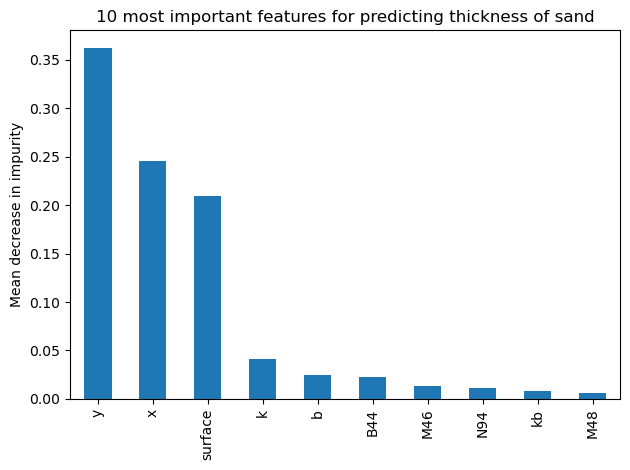

In [30]:
# Evaluate the model (Impurity decrease / feature importance) by plotting the MDI of the
# 10 most important features.
importance = pd.Series(rf_tuned_regressor.feature_importances_, index=features_train.columns)
fig, ax = plt.subplots()
importance.sort_values()[-10:][::-1].plot.bar(ax=ax)
ax.set_title("10 most important features for predicting thickness of sand")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

As you can see, the y-coordinate is the most important discriminator, followed by x and
surface height. The geological map unit 'k' (floodplain) is also important as it
typically indicates more clay/peat and less sand in the subsurface, whereas the
geomorphological unit 'B44' (channel belt) is indicative of more sand in the shallow
subsurface!

# Advanced use: making a map
The fitted model can be used to predict the thickness of sand for any combination of x-,
y-location, surface elevation and geological+geomorphological map units. In this more
advanced section we will create a regular grid of points for which we will run the
prediction using our previously fitted gradient boosting model and then turn the result
in a raster. We will also be using some (spatial) utility function of GeoST.

We will first define a grid and put all the query points in a pandas DataFrame:

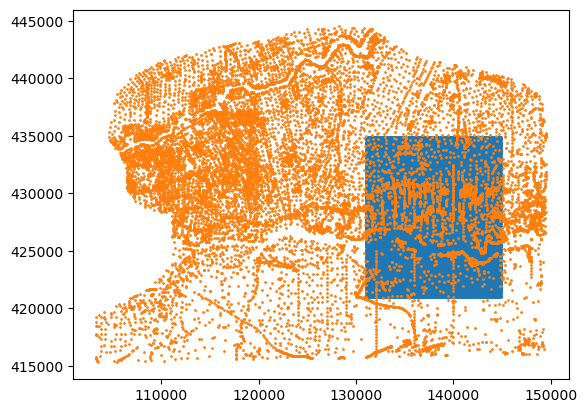

In [31]:
# Grid data
xmin = 131000
xmax = 145000
ymin = 421000
ymax = 435000
resolution = 100

# x and y coordinate arrays
x_coors = np.arange(xmin, xmax, resolution)
y_coors = np.arange(ymin, ymax, resolution)

# Create array with all possible combinations of x and y coordinates and fit in a 
# pandas.DataFrame
query_points = np.array([(x, y) for x, y in product(x_coors, y_coors)])
query_points = pd.DataFrame(query_points, columns=("x", "y"))

# plot to visualize the query points respect to the borehole data
plt.scatter(query_points["x"], query_points["y"], s=1)
plt.scatter(df["x"], df["y"], s=1)

We will now use some GeoST functions to sample the AHN elevation map at the query_points
(`geost.spatial.get_raster_values`)y, to turn a normal dataframe with columns containing 
coordinates into a geopandas Geodataframe containing geometries (`geost.utils.dataframe_to_geodataframe`)
and to assign geological and geomorphological map unit labels to the query_points (`geost.spatial.find_area_labels`).

In [32]:
# Use the get_raster_values function to sample from the AHN elevation map:
query_points["mv"] = get_raster_values(query_points["x"], query_points["y"], ahn_file)

# In order to add geological and geomorphological map units to the query_points
# dataframe we need to turn it into a geodataframe. Luckily we already have the x- and
# y-coordinates in the dataframe, so we can use the handy GeoST function
# 'dataframe_to_geodataframe' to do so and then use the find_area_labels function to add
# geological and geomorphological map unit labels.
query_points = dataframe_to_geodataframe(query_points, crs=28992)
query_points["CODE"] = find_area_labels(query_points, gpd.read_parquet(geological_map_file), "CODE")
query_points["landformsubgroup_code"] = find_area_labels(
    query_points, gpd.read_parquet(geomorphological_map_file), "landformsubgroup_code"
)

We will create two helper functions that we need to fill the grid of query points with
predicted values:

In [33]:
#Function to get predictions from all trees
def get_predictions_from_all_trees(model, features):

    # Get predictions from all trees
    all_tree_predictions = np.array([tree.predict(np.array(features)) for tree in model.estimators_])

    # Calculate mean prediction
    mean_prediction = np.mean(all_tree_predictions,axis=0)
    # Calculate variance (uncertainty) in predictions
    variance = np.var(all_tree_predictions,axis=0)
    # Calculate standard deviation (uncertainty) in predictions
    std_deviation = np.std(all_tree_predictions,axis=0)

    return mean_prediction, variance, std_deviation



# Function to turn a string into the correct encoding
def string_to_encoded_array(row: pd.Series, column: str, encoding: pd.DataFrame):
    """
    Turn a string into encoding based on known one-hot encoding
    """
    string = row[column]
    result = [True if string == col else False for col in encoding]
    return result

# Function that can be applied to query points with feature data and returns predicted
# target values based a the given (fitted) scikit-learn machine learning model.
def model_predictions(
    ml_model,
    query_points,
    numerical_features: list = [],
    encoded_features: dict = {},
    min_allowed_value: int | float = 0,
    max_allowed_value: int | float = np.inf,
) -> np.ndarray:
    """
    Function to predict target values based on a scikit-learn trained ML-model at query
    points (e.g. a grid of points).

    Parameters
    ----------
    ml_model : sklearn.ensemble model
        scikit-learn fitted ensemble regressor model
    query_points : pd.DataFrame
        Pandas DataFrame with labelled columns for each feature that was used to train
        the ml_model on (and will thus be used for the predictions)
    numerical_features : list, optional
        List of numerical feature labels in query_points, by default []
    encoded_features : dict, optional
        Encoded feature labels in query points, mapped to the one-hot encoded dataframe
        for this feature, by default {}
    min_allowed_value : int | float, optional
        Minimum value to predict. If predicted value is lower it is forced to this
        min_allowed_value. By default 0.
    max_allowed_value : int | float, optional
        Maximum value to predict. If predicted value is higher it is forced to this
        max_allowed_value. By default np.inf

    Returns
    -------
    np.ndarray
        Numpy array with prediction results
    """
    predictions = []
    feature_labels = numerical_features

    for key, encodings in encoded_features.items():
        query_points[encodings.columns] = query_points.apply(
            string_to_encoded_array,
            args=(key, encodings.columns),
            axis=1,
            result_type="expand",
        )
        feature_labels += list(encodings.columns)

    #predictions = ml_model.predict(query_points[feature_labels].values)

    predictions, variance, std_deviation = get_predictions_from_all_trees(ml_model, query_points[feature_labels].values)


    predictions[predictions < min_allowed_value] = min_allowed_value
    
    predictions[predictions > max_allowed_value] = max_allowed_value

    return predictions, variance, std_deviation

With the help of the `model_predictions` function, we will predict the total thickness
of sand using the tuned Random Forest regressor for all query points.

In [34]:
predictions, variance, std_deviation = model_predictions(
    rf_tuned_regressor,
    query_points,
    numerical_features=["x", "y", "mv"],
    encoded_features={
        "CODE": data_encoded_geology,
        "landformsubgroup_code": data_encoded_morphology,
    },
    min_allowed_value=0,
    max_allowed_value=4,
)

query_points["predicted_z_thickness"] = predictions
query_points["variance"] = variance


Next we reshape query_points to a 2D array and turn it into an Xarray.DataArray with
labelled coordinates

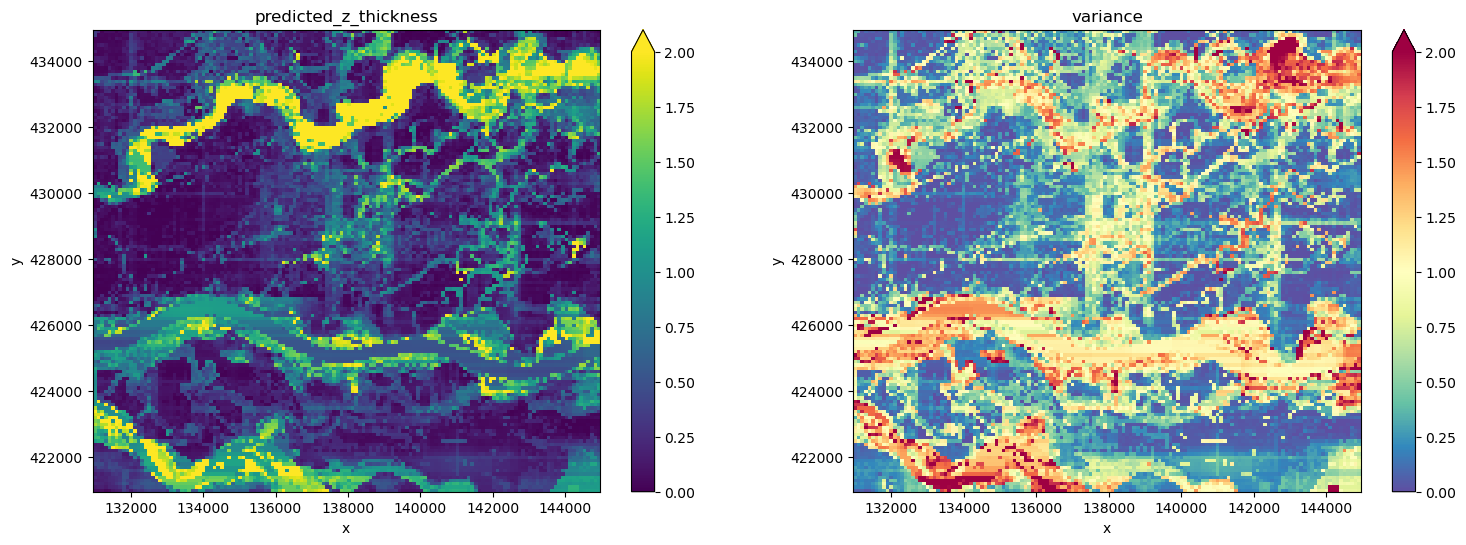

In [35]:

fig,axs = plt.subplots(1,2,figsize=(18,6))

cmap_list = ["viridis", "Spectral_r"]

for idx, var in enumerate(["predicted_z_thickness", "variance"]):
    predicted_z_thickness_array = query_points[var].values.reshape((len(x_coors), len(y_coors)))
    predicted_z_thickness_da = xr.DataArray(predicted_z_thickness_array, 
                                            coords={"x": x_coors, "y": y_coors}
                                            ).transpose("y", "x")

    predicted_z_thickness_da.plot.imshow(ax=axs[idx],cmap=cmap_list[idx],vmin=0,vmax=2)
    axs[idx].set_title(var)


Finally, let's visualize the results

You can clearly see the relation between the predicted sand thickness and certain 
geological and geomorphological units. In order to somehow estimate the uncertainty predicted thicknesses, we utlized the covariance caclualted from all the estimators utilized by the RF estimator. Thus, the covariance map shows the degree of dispersion of the predicted thicknesses. 


## Model Explainability

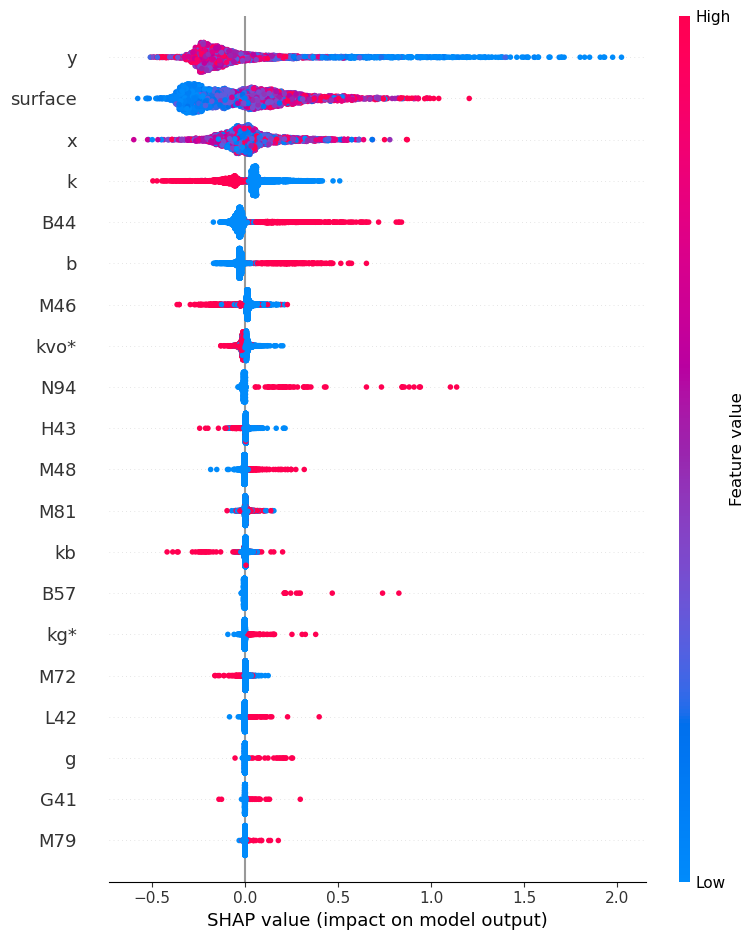

In [36]:
# explain all the predictions in the test set
explainer = shap.TreeExplainer(rf_tuned_regressor)
shap_values = explainer.shap_values(features_test)
shap.summary_plot(shap_values, features_test)

## Observations

The shap plot shows the impact of each feature in the output of the model. The higher the value of the feature, the more it contributes to the prediction. In this case the features with highest importance are the y, followed by x, surface, and k. In y the lower values seem to have the highiest impact in the model. 